In [1]:
import pandas as pd
from tables import *
import numpy as np
from tqdm import tqdm_notebook as tqdm
import csv
from scipy import sparse
import pickle

In [2]:
path = '/home/User1/data/self_citations/'

In [3]:
min_year = 1980
max_year = 2020
nb_years = max_year-min_year

In [4]:
disciplines = pd.read_csv(path+'liste_discipline.txt',encoding='latin_1',sep='\t')
list_disciplines = pd.unique(disciplines['EDiscipline'])
nb_disciplines = len(list_disciplines)

In [5]:
types_cit = ['self','co','others']

references = {}
citations = {}
for type_cit in types_cit:
    with open('{}/arrays/references_{}_array.p'.format(path,type_cit),'rb') as f:
        references[type_cit] = pickle.load(f)
    if not type_cit == 'others':
        with open('{}/arrays/citations_{}_array.p'.format(path,type_cit),'rb') as f:
            citations[type_cit] = pickle.load(f)


citations['others'] = {}
for disc in list_disciplines:
    with open('{}/arrays/citations_{}_{}_array.p'.format(path,'others',disc),'rb') as f:
        citations['others'][disc] = pickle.load(f)

for type_cit in types_cit:
    for disc in list_disciplines:
        references[type_cit][disc] = sparse.csr_matrix(references[type_cit][disc])
        citations[type_cit][disc] = sparse.csr_matrix(citations[type_cit][disc])

references = {}
citations = {}
for type_cit in types_cit:
    for disc in list_disciplines:
        sparse.save_npz('{}/sparse_arrays/citations_{}_{}_array.p'.format(path,type_cit,disc),citations[type_cit][disc])
        sparse.save_npz('{}/sparse_arrays/references_{}_{}_array.p'.format(path,type_cit,disc),references[type_cit][disc])

In [6]:
from matplotlib import pyplot as plt

### Proportion of citations

In [59]:
for i in range(nb_disciplines):
    disc = list_disciplines[i]
    arrays_refs = {}
    arrays_cits = {}
    for type_cit in types_cit:
        arrays_refs[type_cit] = references[type_cit][disc].todense()
        arrays_cits[type_cit] = citations[type_cit][disc].todense()
    
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    total_refs_cumul = np.sum(total_refs,axis=1)
    total_cits_cumul = np.sum(total_cits,axis=1)
    rows_refs = np.where(total_refs_cumul)[0]
    rows_cits = np.where(total_cits_cumul)[0]
    
    plot_types = ['self','co']
    stats_refs = {}
    stats_cits = {}
    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
        arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 
        
        idx_cits = total_cits.nonzero()
        idx_refs = total_refs.nonzero()
        arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
        arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100
        
#         arrays_refs[type_cit + '_perc_cumul'] = sparse.csr_matrix(arrays_refs[type_cit].shape) 
#         arrays_cits[type_cit + '_perc_cumul'] = sparse.csr_matrix(arrays_cits[type_cit].shape) 
#         arrays_refs[type_cit + '_perc_cumul'] = sparse.csr_matrix(arrays_refs[type_cit].shape) 
#         arrays_refs[type_cit + '_perc_cumul'][rows_refs] = (np.cumsum(arrays_refs[type_cit][rows_refs,:])[0]/
#                                                                            total_refs_cumul[rows_refs])*100
#         arrays_cits[type_cit + '_perc_cumul'] = sparse.csr_matrix(arrays_cits[type_cit].shape) 
#         arrays_cits[type_cit + '_perc_cumul'][rows_cits] = (np.cumsum(arrays_cits[type_cit][rows_cits,:])[0]/
#                                                                            total_cits_cumul[rows_cits])*100

        
        count_cits = np.count_nonzero(total_cits,axis=0)
        idx_count_cits = np.where(count_cits)[1]
        stats_cits[type_cit + '_perc_year'] = np.zeros(nb_years)
        stats_cits[type_cit + '_perc_year'][idx_count_cits] = np.divide(np.sum(arrays_cits[type_cit + '_perc_year'],axis=0)[idx_count_cits],
                                                                       count_cits[0,idx_count_cits])
        
        
        count_refs = np.count_nonzero(total_refs,axis=0)
        idx_count_refs = np.where(count_refs)[1]
        stats_refs[type_cit + '_perc_year'] = np.zeros(nb_years)
        stats_refs[type_cit + '_perc_year'][idx_count_refs] = np.divide(np.sum(arrays_refs[type_cit + '_perc_year'],axis=0)[idx_count_refs],
                                                                        count_refs[0,idx_count_refs])
        
#         #Modify this next
#         count_cits = np.count_nonzero(total_cits.todense(),axis=0)
#         idx_count_cits = np.where(count_cits)[0]
#         stats_cits[type_cit + '_perc_year'] = np.zeros(nb_years)
#         stats_cits[type_cit + '_perc_year'][idx_count_cits] = np.divide(np.sum(arrays_cits[type_cit + '_perc_year'],axis=0)[0,idx_count_cits],
#                                                                         count_cits[0,idx_count_cits])
        
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.plot(stats_cits['self_perc_year'][:37],'r',label='% self citations')
    plt.plot(stats_cits['co_perc_year'][:37],'r--',label='% coauthors citations')
    plt.plot(stats_refs['self_perc_year'][:37],'g',label='% self references')
    plt.plot(stats_refs['co_perc_year'][:37],'g--',label='% coauthors references')
    plt.title(disc)
    plt.ylabel('%')
    plt.xlabel('Year since first publication')
    plt.legend()


    plt.subplot(122)
    plt.plot(stats_cits['self_perc_year'][:37] + stats_cits['co_perc_year'][:37] ,'b',label='% citations')
    plt.plot(stats_refs['self_perc_year'][:37]+stats_refs['co_perc_year'][:37],'orange',label = '% references')
    plt.title(disc)
    plt.ylabel('%')
    plt.xlabel('Year since first publication')
    plt.legend()

    
    
    plt.ylabel('%')
    plt.xlabel('Year of publication')
    plt.legend()
    #plt.show()
    plt.savefig(path+'figs/' + disc + '.png')
    plt.close()

   

### Get raw count of citations

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


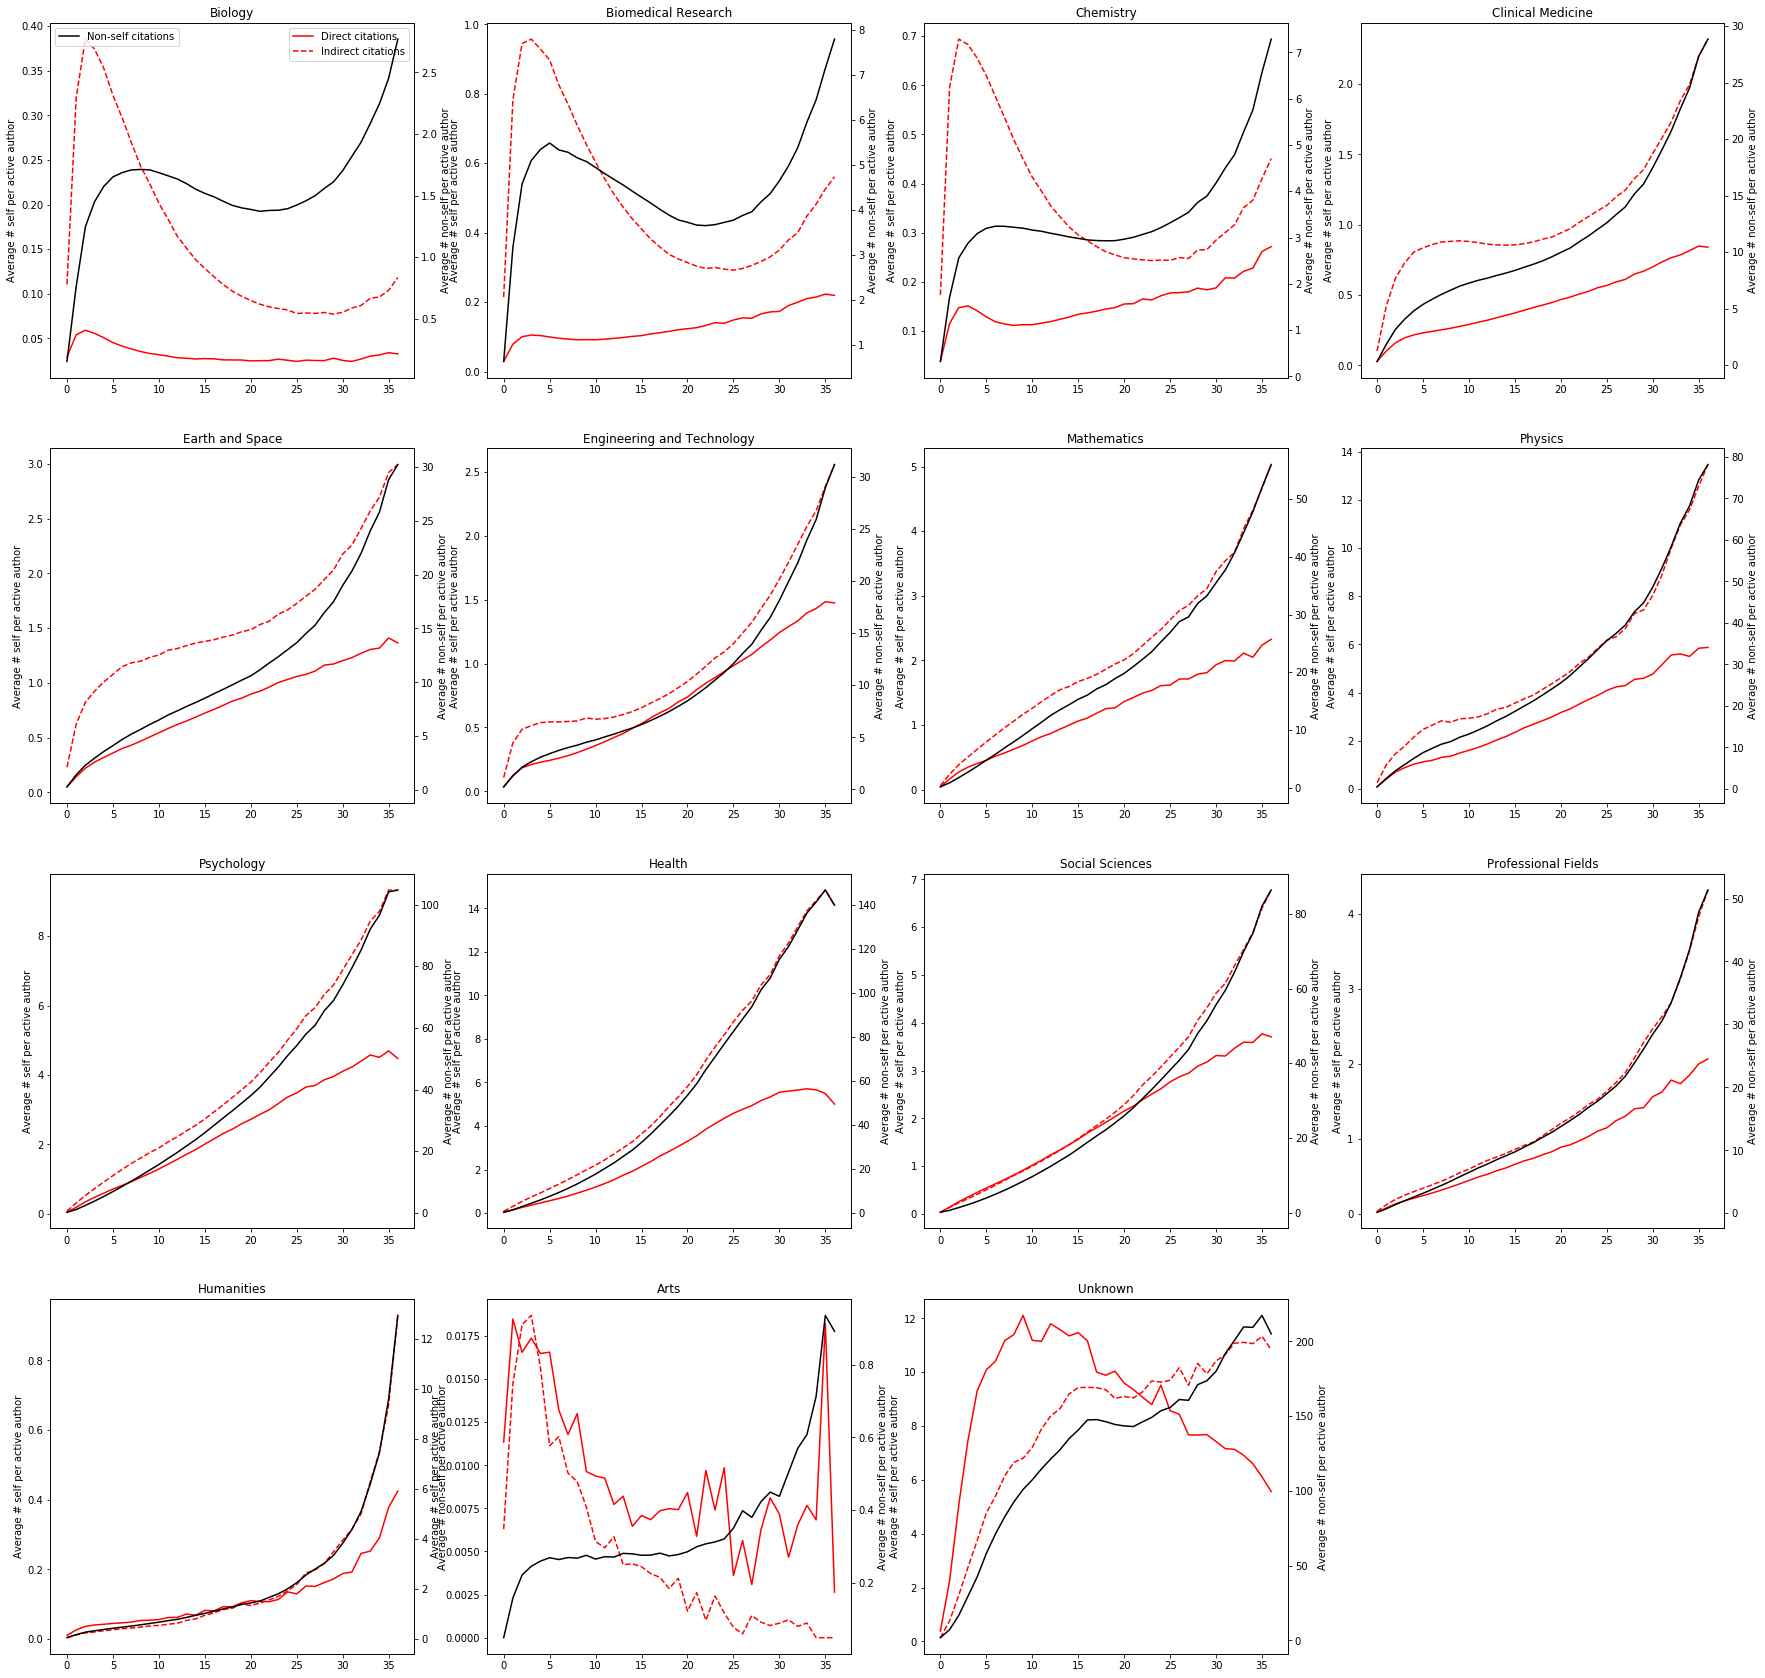

In [12]:
plt.figure(figsize=(30,30))
for i in range(nb_disciplines):
    print(i)
    disc = list_disciplines[i]
    arrays_cits = {}
    for type_cit in types_cit:
        arrays_cits[type_cit] = sparse.load_npz('{}/sparse_arrays/citations_{}_{}_array.p.npz'.format(path,type_cit,disc)).todense()
    active = np.zeros(arrays_cits[type_cit].shape)
    last_nz = (arrays_cits[type_cit]!=0).cumsum(1).argmax(1)
    nb_cit = np.sum(arrays_cits[type_cit],axis=1)
    for j in range(active.shape[0]):
        if nb_cit[j] > 0:
            last_idx = np.asarray(last_nz[j])[0][0]
            active[j,:last_idx+1] = 1
    nb_active = np.sum(active,axis=0)
    plot_types = ['self','co','others']
    stats_cits = {}
    #idx_active = np.where()
    for type_cit in plot_types:
        #stats_cits[type_cit + '_count_year'] = np.zeros(nb_years)
        stats_cits[type_cit + '_count_year'] = np.divide(np.squeeze(np.asarray(np.sum(arrays_cits[type_cit],axis=0))),nb_active)
    
        
    plt.subplot(4,4,i+1)
    plt.plot(stats_cits['self_count_year'][:37],'r',label='Direct citations')
    plt.plot(stats_cits['co_count_year'][:37],'r--',label='Indirect citations')
    plt.ylabel('Average # self per active author')
    if i == 0:
        plt.legend()
    plt.twinx()
    plt.plot(stats_cits['others_count_year'][:37],'k',label='Non-self citations')
    plt.title(disc)
    plt.ylabel('Average # non-self per active author')
    plt.xlabel('Year since first publication')
    if i == 0:
        plt.legend()
plt.savefig(path+'figs/avg_count.png')
plt.show()



In [8]:
nb_active

array([1559254., 1489052., 1395971., 1303506., 1215025., 1131674.,
       1053989.,  980706.,  913024.,  848445.,  787117.,  729042.,
        674151.,  623576.,  574578.,  528802.,  486070.,  445765.,
        408132.,  372351.,  337507.,  305250.,  274770.,  247096.,
        220710.,  196313.,  173299.,  151877.,  132331.,  114005.,
         96647.,   80542.,   65594.,   51786.,   38743.,   27096.,
         16590.,    7110.,    2625.,       0.])

In [9]:
np.squeeze(np.asarray(np.sum(arrays_cits[type_cit],axis=0)))

KeyError: 'co'